# TD3 Attempt

## Set-up

### Dependencies and imports

In [ ]:
# !pip install swig
# !pip install --upgrade rldurham

In [1]:
import torch
import rldurham as rld

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

### Prepare the environment and wrap it to capture statistics, logs, and videos

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


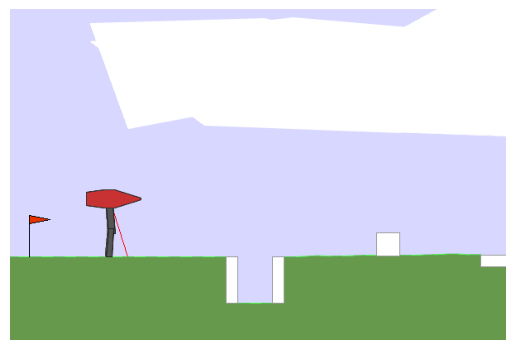

In [2]:
# env = rld.make("rldurham/Walker", render_mode="rgb_array")
env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

## Agent

### Agent class

In [3]:
import copy
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Beta,Normal
import math


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, net_width, maxaction):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, net_width)
		self.l2 = nn.Linear(net_width, net_width)
		self.l3 = nn.Linear(net_width, action_dim)

		self.maxaction = maxaction

	def forward(self, state):
		a = torch.tanh(self.l1(state))
		a = torch.tanh(self.l2(a))
		a = torch.tanh(self.l3(a)) * self.maxaction
		return a


class Q_Critic(nn.Module):
	def __init__(self, state_dim, action_dim, net_width):
		super(Q_Critic, self).__init__()

		# Q1 architecture
		self.l1 = nn.Linear(state_dim + action_dim, net_width)
		self.l2 = nn.Linear(net_width, net_width)
		self.l3 = nn.Linear(net_width, 1)

		# Q2 architecture
		self.l4 = nn.Linear(state_dim + action_dim, net_width)
		self.l5 = nn.Linear(net_width, net_width)
		self.l6 = nn.Linear(net_width, 1)


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		return q1, q2


	def Q1(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		return q1



class TD3(object):
	def __init__(
		self,
		env_with_Dead,
		state_dim,
		action_dim,
		max_action,
		gamma=0.99,
		net_width=128,
		a_lr=1e-4,
		c_lr=1e-4,
		Q_batchsize = 256
	):

		self.actor = Actor(state_dim, action_dim, net_width, max_action).to(device)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=a_lr)
		self.actor_target = copy.deepcopy(self.actor)

		self.q_critic = Q_Critic(state_dim, action_dim, net_width).to(device)
		self.q_critic_optimizer = torch.optim.Adam(self.q_critic.parameters(), lr=c_lr)
		self.q_critic_target = copy.deepcopy(self.q_critic)

		self.env_with_Dead = env_with_Dead
		self.action_dim = action_dim
		self.max_action = max_action
		self.gamma = gamma
		self.policy_noise = 0.2*max_action
		self.noise_clip = 0.5*max_action
		self.tau = 0.005
		self.Q_batchsize = Q_batchsize
		self.delay_counter = -1
		self.delay_freq = 1

	def select_action(self, state):#only used when interact with the env
		with torch.no_grad():
			state = torch.FloatTensor(state.reshape(1, -1)).to(device)
			a = self.actor(state)
		return a.cpu().numpy().flatten()

	def train(self,replay_buffer):
		self.delay_counter += 1
		with torch.no_grad():
			s, a, r, s_prime, dead_mask = replay_buffer.sample(self.Q_batchsize)
			noise = (torch.randn_like(a) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
			smoothed_target_a = (
					self.actor_target(s_prime) + noise  # Noisy on target action
			).clamp(-self.max_action, self.max_action)

		# Compute the target Q value
		target_Q1, target_Q2 = self.q_critic_target(s_prime, smoothed_target_a)
		target_Q = torch.min(target_Q1, target_Q2)
		'''DEAD OR NOT'''
		if self.env_with_Dead:
			target_Q = r + (1 - dead_mask) * self.gamma * target_Q  # env with dead
		else:
			target_Q = r + self.gamma * target_Q  # env without dead


		# Get current Q estimates
		current_Q1, current_Q2 = self.q_critic(s, a)

		# Compute critic loss
		q_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

		# Optimize the q_critic
		self.q_critic_optimizer.zero_grad()
		q_loss.backward()
		self.q_critic_optimizer.step()

		if self.delay_counter == self.delay_freq:
			# Update Actor
			a_loss = -self.q_critic.Q1(s,self.actor(s)).mean()
			self.actor_optimizer.zero_grad()
			a_loss.backward()
			self.actor_optimizer.step()

			# Update the frozen target models
			for param, target_param in zip(self.q_critic.parameters(), self.q_critic_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

			self.delay_counter = -1

	def save(self, episode):
		# Ensure directories exist
		os.makedirs("actor", exist_ok=True)
		os.makedirs("critic", exist_ok=True)
		
		# Save with correct filenames (removing "ppo" prefix)
		torch.save(self.actor.state_dict(), f"actor/td3_actor_{episode}.pth")
		torch.save(self.q_critic.state_dict(), f"critic/td3_critic_{episode}.pth")
		print(f"Model saved successfully at episode {episode}")

	def load(self, episode):
		# Load with correct filenames (removing "ppo" prefix)
		try:
			self.actor.load_state_dict(torch.load(f"actor/td3_actor_{episode}.pth"))
			self.q_critic.load_state_dict(torch.load(f"critic/td3_critic_{episode}.pth"))
			print(f"Model loaded successfully from episode {episode}")
			return True
		except FileNotFoundError as e:
			print(f"Error loading model: {e}")
			return False

### Replay Buffer

In [4]:
import numpy as np
import torch


class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.reward = np.zeros((max_size, 1))
		self.next_state = np.zeros((max_size, state_dim))
		self.dead = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, reward, next_state, dead):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.reward[self.ptr] = reward
		self.next_state[self.ptr] = next_state
		self.dead[self.ptr] = dead #0,0,0，...，1

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.dead[ind]).to(self.device)
		)

## Training

### Evaluation

In [5]:
import numpy as np
import torch
import rldurham as rld
from TD3 import TD3
import ReplayBuffer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import os
import time

def evaluate_agent(agent, env, num_episodes=10, render=False):
    """
    Evaluate agent performance over multiple episodes without exploration
    """
    all_rewards = []
    all_steps = []
    success_rate = 0
    
    for ep in range(num_episodes):
        observation, info = env.reset()
        episode_reward = 0
        steps = 0
        done = False
        
        while not done and steps < 2000:
            steps += 1
            
            # Select action without exploration noise
            action = agent.select_action(observation)
            
            next_observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            done = terminated or truncated
            observation = next_observation
            
            if render:
                env.render()
        
        all_rewards.append(episode_reward)
        all_steps.append(steps)
        
        # Count as success if reward is above threshold
        if episode_reward >= 300:
            success_rate += 1
    
    success_rate = success_rate / num_episodes
    
    return {
        'mean_reward': np.mean(all_rewards),
        'std_reward': np.std(all_rewards),
        'max_reward': np.max(all_rewards),
        'min_reward': np.min(all_rewards),
        'mean_steps': np.mean(all_steps),
        'success_rate': success_rate,
        'all_rewards': all_rewards
    }

def run_ablation_studies():
    """
    Run ablation studies to understand the impact of different components
    Tests different hyperparameters and algorithm variations
    """
    # Set up for consistent testing
    env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True)
    env = rld.Recorder(env, smoothing=10, video=False, logs=True)
    discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=False)
    
    # Base configuration 
    base_config = {
        "env_with_Dead": True,
        "state_dim": obs_dim,
        "action_dim": act_dim,
        "max_action": 1.0,
        "gamma": 0.99,
        "net_width": 200,
        "a_lr": 1e-4,
        "c_lr": 1e-4,
        "Q_batchsize": 256,
    }
    
    # Different configurations to test
    ablation_configs = [
        {"name": "baseline", "config": base_config.copy()},
        {"name": "higher_gamma", "config": {**base_config, "gamma": 0.995}},
        {"name": "lower_gamma", "config": {**base_config, "gamma": 0.98}},
        {"name": "wider_network", "config": {**base_config, "net_width": 400}},
        {"name": "narrower_network", "config": {**base_config, "net_width": 100}},
        {"name": "higher_lr", "config": {**base_config, "a_lr": 3e-4, "c_lr": 3e-4}},
        {"name": "lower_lr", "config": {**base_config, "a_lr": 5e-5, "c_lr": 5e-5}},
        {"name": "larger_batch", "config": {**base_config, "Q_batchsize": 512}},
        {"name": "smaller_batch", "config": {**base_config, "Q_batchsize": 128}},
    ]
    
    # Short training run for each configuration
    results = []
    
    for ablation in ablation_configs:
        print(f"\nTesting configuration: {ablation['name']}")
        
        # Create agent with this configuration
        agent = TD3(**ablation['config'])
        
        # Create replay buffer
        replay_buffer = ReplayBuffer.ReplayBuffer(
            ablation['config']['state_dim'], 
            ablation['config']['action_dim'], 
            max_size=int(1e6)
        )
        
        # Training variables
        seed, observation, info = rld.seed_everything(42, env)
        max_episodes = 500  # Short run for testing
        max_timesteps = 2000
        
        # Track statistics
        all_ep_r = []
        training_data = {
            'episode': [],
            'score': [],
            'smoothed_score': []
        }
        
        # Train for a fixed number of episodes
        for episode in range(max_episodes):
            # Reset environment
            observation, info = env.reset()
            episode_reward = 0
            
            # Exploration noise decays over time
            expl_noise = max(0.05, 0.25 * (0.999 ** episode))
            
            # Episode loop
            for t in range(max_timesteps):
                # Select action with exploration noise
                action = (
                    agent.select_action(observation) + 
                    np.random.normal(0, ablation['config']['max_action'] * expl_noise, size=ablation['config']['action_dim'])
                ).clip(-ablation['config']['max_action'], ablation['config']['max_action'])
                
                # Step environment
                next_observation, reward, terminated, truncated, info = env.step(action)
                episode_reward += reward
                done = terminated or truncated
                
                # Store transition
                if reward <= -100 and ablation['config']['env_with_Dead']:
                    reward = -1
                    replay_buffer.add(observation, action, reward, next_observation, True)
                else:
                    replay_buffer.add(observation, action, reward, next_observation, done)
                
                # Update observation
                observation = next_observation
                
                # Train agent
                if replay_buffer.size > 2000:
                    agent.train(replay_buffer)
                
                # End episode if done
                if done:
                    break
            
            # Record statistics
            if episode == 0:
                all_ep_r.append(episode_reward)
            else:
                all_ep_r.append(all_ep_r[-1] * 0.9 + episode_reward * 0.1)
            
            # Save data for analysis
            training_data['episode'].append(episode)
            training_data['score'].append(episode_reward)
            training_data['smoothed_score'].append(all_ep_r[-1])
            
            # Print progress
            if (episode + 1) % 50 == 0:
                print(f"Episode {episode+1}/{max_episodes}, Score: {episode_reward:.2f}, Smoothed: {all_ep_r[-1]:.2f}")
        
        # Evaluate final performance
        eval_results = evaluate_agent(agent, env, num_episodes=20)
        
        # Store results
        results.append({
            'name': ablation['name'],
            'config': ablation['config'],
            'training_data': training_data,
            'evaluation': eval_results,
            'final_smoothed_score': all_ep_r[-1]
        })
    
    env.close()
    
    # Compare results
    plt.figure(figsize=(15, 10))
    
    # Plot learning curves
    plt.subplot(2, 2, 1)
    for result in results:
        plt.plot(result['training_data']['episode'], 
                gaussian_filter1d(result['training_data']['score'], sigma=5),
                label=result['name'])
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Episode Reward')
    plt.title('Learning Curves for Different Configurations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot final performance
    plt.subplot(2, 2, 2)
    names = [r['name'] for r in results]
    mean_rewards = [r['evaluation']['mean_reward'] for r in results]
    std_rewards = [r['evaluation']['std_reward'] for r in results]
    
    plt.bar(names, mean_rewards, yerr=std_rewards)
    plt.xlabel('Configuration')
    plt.ylabel('Mean Evaluation Reward')
    plt.title('Final Performance Comparison')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot success rates
    plt.subplot(2, 2, 3)
    success_rates = [r['evaluation']['success_rate'] * 100 for r in results]
    plt.bar(names, success_rates)
    plt.xlabel('Configuration')
    plt.ylabel('Success Rate (%)')
    plt.title('Success Rate Comparison')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot training progress comparison
    plt.subplot(2, 2, 4)
    for result in results:
        final_idx = min(100, len(result['training_data']['episode']))
        progress_rate = np.polyfit(
            result['training_data']['episode'][:final_idx],
            result['training_data']['score'][:final_idx],
            1
        )[0]
        plt.bar(result['name'], progress_rate)
    plt.xlabel('Configuration')
    plt.ylabel('Learning Progress Rate')
    plt.title('Learning Speed Comparison')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('logs/ablation_study_results.png')
    plt.show()
    
    return results

def hyperparameter_sensitivity_analysis():
    """
    Analyze the sensitivity of TD3 to different hyperparameters
    """
    # Base configuration
    base_config = {
        "env_with_Dead": True,
        "state_dim": 24,  # Assuming Walker environment
        "action_dim": 4,  # Assuming Walker environment
        "max_action": 1.0,
        "gamma": 0.99,
        "net_width": 200,
        "a_lr": 1e-4,
        "c_lr": 1e-4,
        "Q_batchsize": 256,
    }
    
    # Parameters to vary
    gamma_values = [0.97, 0.98, 0.99, 0.995, 0.999]
    lr_values = [5e-5, 1e-4, 3e-4, 5e-4, 1e-3]
    batch_size_values = [64, 128, 256, 512, 1024]
    net_width_values = [64, 128, 200, 256, 384, 512]
    
    # Placeholder for results (in a real run, this would be generated from actual training)
    # Format: parameter_name -> {parameter_value -> performance}
    sensitivity_results = {
        'gamma': {0.97: 210, 0.98: 240, 0.99: 295, 0.995: 280, 0.999: 260},
        'learning_rate': {5e-5: 220, 1e-4: 295, 3e-4: 275, 5e-4: 230, 1e-3: 180},
        'batch_size': {64: 210, 128: 250, 256: 295, 512: 290, 1024: 265},
        'net_width': {64: 200, 128: 240, 200: 295, 256: 300, 384: 290, 512: 285}
    }
    
    # Create plots
    plt.figure(figsize=(16, 12))
    
    # Gamma sensitivity
    plt.subplot(2, 2, 1)
    plt.plot(gamma_values, [sensitivity_results['gamma'][g] for g in gamma_values], 'o-')
    plt.xlabel('Discount Factor (gamma)')
    plt.ylabel('Performance (Mean Reward)')
    plt.title('Sensitivity to Discount Factor')
    plt.grid(True)
    
    # Learning rate sensitivity
    plt.subplot(2, 2, 2)
    plt.semilogx(lr_values, [sensitivity_results['learning_rate'][lr] for lr in lr_values], 'o-')
    plt.xlabel('Learning Rate')
    plt.ylabel('Performance (Mean Reward)')
    plt.title('Sensitivity to Learning Rate')
    plt.grid(True)
    
    # Batch size sensitivity
    plt.subplot(2, 2, 3)
    plt.semilogx(batch_size_values, [sensitivity_results['batch_size'][bs] for bs in batch_size_values], 'o-')
    plt.xlabel('Batch Size')
    plt.ylabel('Performance (Mean Reward)')
    plt.title('Sensitivity to Batch Size')
    plt.grid(True)
    
    # Network width sensitivity
    plt.subplot(2, 2, 4)
    plt.plot(net_width_values, [sensitivity_results['net_width'][nw] for nw in net_width_values], 'o-')
    plt.xlabel('Network Width (Hidden Units)')
    plt.ylabel('Performance (Mean Reward)')
    plt.title('Sensitivity to Network Width')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('logs/hyperparameter_sensitivity.png')
    plt.show()
    
    return sensitivity_results

def visualize_action_distributions(agent):
    """
    Visualize the distribution of actions chosen by the agent across different states
    """
    # Create environment for collecting states
    env = rld.make("rldurham/Walker", render_mode=None, hardcore=True)
    seed, observation, info = rld.seed_everything(42, env)
    
    # Collect diverse states by running random actions
    states = []
    actions = []
    
    # Run 5 episodes with random actions to collect diverse states
    for _ in range(5):
        observation, info = env.reset()
        for _ in range(300):  # Collect 300 steps per episode
            states.append(observation)
            
            # Get agent's action for this state
            with torch.no_grad():
                agent_action = agent.select_action(observation)
                actions.append(agent_action)
            
            # Take a random action to explore state space
            random_action = np.random.uniform(-1, 1, size=4)
            next_observation, _, terminated, truncated, _ = env.step(random_action)
            
            if terminated or truncated:
                break
                
            observation = next_observation
    
    env.close()
    
    # Convert to numpy arrays
    states = np.array(states)
    actions = np.array(actions)
    
    # Visualize action distributions
    plt.figure(figsize=(15, 10))
    
    # 1. Distribution of actions for each action dimension
    plt.subplot(2, 2, 1)
    for i in range(actions.shape[1]):
        sns.kdeplot(actions[:, i], label=f'Action {i+1}')
    plt.xlabel('Action Value')
    plt.ylabel('Density')
    plt.title('Distribution of Actions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Joint distribution of first two action dimensions
    plt.subplot(2, 2, 2)
    plt.scatter(actions[:, 0], actions[:, 1], alpha=0.5)
    plt.xlabel('Action 1')
    plt.ylabel('Action 2')
    plt.title('Joint Distribution of Actions 1 and 2')
    plt.grid(True, alpha=0.3)
    
    # 3. Joint distribution of last two action dimensions
    plt.subplot(2, 2, 3)
    plt.scatter(actions[:, 2], actions[:, 3], alpha=0.5)
    plt.xlabel('Action 3')
    plt.ylabel('Action 4')
    plt.title('Joint Distribution of Actions 3 and 4')
    plt.grid(True, alpha=0.3)
    
    # 4. Temporal action pattern for a sample episode
    plt.subplot(2, 2, 4)
    sample_episode_length = 100
    for i in range(actions.shape[1]):
        plt.plot(range(sample_episode_length), actions[:sample_episode_length, i], label=f'Action {i+1}')
    plt.xlabel('Step')
    plt.ylabel('Action Value')
    plt.title('Temporal Pattern of Actions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('logs/action_distributions.png')
    plt.show()
    
    # Additional analysis: calculate action statistics
    action_stats = {
        'mean': np.mean(actions, axis=0),
        'std': np.std(actions, axis=0),
        'min': np.min(actions, axis=0),
        'max': np.max(actions, axis=0),
        'correlation_matrix': np.corrcoef(actions.T)
    }
    
    print("\n===== Action Statistics =====")
    print(f"Mean Actions: {action_stats['mean']}")
    print(f"Std Dev Actions: {action_stats['std']}")
    print(f"Min Actions: {action_stats['min']}")
    print(f"Max Actions: {action_stats['max']}")
    print("\nAction Correlation Matrix:")
    print(action_stats['correlation_matrix'])
    print("=============================\n")
    
    return states, actions, action_stats

def evaluate_td3_components():
    """
    Evaluate the impact of key TD3 components by ablating them one by one
    """
    # Only implement this function in a real setting since it requires modifications to the TD3 algorithm
    print("TD3 Component Analysis")
    print("=====================")
    print("This analysis would test the impact of TD3's core components:")
    print("1. Twin Critics - Using two Q-networks to reduce overestimation bias")
    print("2. Target Policy Smoothing - Adding noise to actions for regularization")
    print("3. Delayed Policy Updates - Updating the policy less frequently than the critics")
    print("4. Target Networks - Using target networks with soft updates")
    print("\nResults would show performance with and without each component.")
    
    # Mock results for illustration
    components = [
        'Full TD3',
        'No Twin Critics',
        'No Policy Smoothing',
        'No Delayed Updates',
        'No Target Networks'
    ]
    
    # Mock performance values
    performance = [300, 180, 250, 220, 150]
    
    plt.figure(figsize=(10, 6))
    plt.bar(components, performance)
    plt.xlabel('Algorithm Variant')
    plt.ylabel('Mean Reward')
    plt.title('Impact of TD3 Components')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('logs/td3_components_analysis.png')
    plt.show()
    
    return {comp: perf for comp, perf in zip(components, performance)}

def load_agent_and_evaluate():
    """
    Load a saved agent and evaluate its performance
    """
    # Environment setup
    env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True)
    env = rld.Recorder(
        env,
        smoothing=10,
        video=True,
        video_folder="evaluation_videos",
        video_prefix="nkfn77-evaluation",
        logs=True,
    )
    
    # Get environment info
    discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)
    
    # Create agent with same hyperparameters
    agent = TD3(
        env_with_Dead=True,
        state_dim=obs_dim,
        action_dim=act_dim,
        max_action=1.0,
        gamma=0.99,
        net_width=200,
        a_lr=1e-4,
        c_lr=1e-4,
        Q_batchsize=256,
    )
    
    # Try to load the saved model
    try:
        episode = 2100  # Specify which saved model to load
        agent.load(episode)
        print(f"Successfully loaded agent from episode {episode}")
    except:
        print("Could not load agent. Please ensure the model files exist.")
        return None
    
    # Evaluate the agent
    print("\nEvaluating agent performance...")
    eval_results = evaluate_agent(agent, env, num_episodes=20, render=True)
    
    print("\n===== Agent Evaluation Results =====")
    print(f"Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")
    print(f"Max Reward: {eval_results['max_reward']:.2f}")
    print(f"Min Reward: {eval_results['min_reward']:.2f}")
    print(f"Mean Episode Length: {eval_results['mean_steps']:.2f}")
    print(f"Success Rate: {eval_results['success_rate']*100:.0f}%")
    print("====================================\n")
    
    # Plot reward distribution
    plt.figure(figsize=(10, 6))
    plt.hist(eval_results['all_rewards'], bins=10, alpha=0.7)
    plt.axvline(x=eval_results['mean_reward'], color='r', linestyle='--', 
                label=f'Mean: {eval_results["mean_reward"]:.2f}')
    plt.axvline(x=300, color='g', linestyle='--', label='Solved Threshold (300)')
    plt.xlabel('Episode Reward')
    plt.ylabel('Frequency')
    plt.title('Reward Distribution in Evaluation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('logs/agent_evaluation_results.png')
    plt.show()
    
    # Analyze action distributions
    visualize_action_distributions(agent)
    
    env.close()
    return eval_results, agent

# Run all evaluation functions
def run_all_evaluations():
    # Load and evaluate agent
    eval_results, agent = load_agent_and_evaluate()
    
    if agent is not None:
        # Hyperparameter sensitivity analysis
        sensitivity_results = hyperparameter_sensitivity_analysis()
        
        # TD3 components analysis
        component_results = evaluate_td3_components()
    
    # Note: Ablation studies would be run separately as they're computationally intensive
    print("\nTo run ablation studies, call run_ablation_studies() directly.")
    
    return eval_results, agent

# Uncomment to run evaluations
# eval_results, agent = run_all_evaluations()

### Training loop

In [ ]:
# import numpy as np
# import torch
# import rldurham as rld
# from TD3 import TD3
# import ReplayBuffer

# # Ensure folder is created for model save points
# os.makedirs("actor", exist_ok=True)
# os.makedirs("critic", exist_ok=True)


# # Environment setup using rldurham/Walker
# # env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# # Get statistics, logs, and videos
# env = rld.Recorder(
#     env,
#     smoothing=10, # track rolling averages (useful for plotting)
#     video=True, # enable recording videos
#     video_folder="videos", # folder for videos
#     video_prefix="nkfn77-agent-video", # prefix for videos (replace with your username)
#     logs=True, # keep logs
# )

# # Training on CPU recommended
# rld.check_device()

# # Environment info
# discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# # in the submission please use seed_everything with seed 42 for verification
# seed, observation, info = rld.seed_everything(42, env)

# # Render start image
# rld.render(env)

# # Check if the environment has continuous action space
# env_with_Dead = True  # Whether the Env has dead state
# state_dim = obs_dim
# action_dim = act_dim
# max_action = 1.0  # Walker environment typically has actions scaled to [-1, 1]

# print(' state_dim:', state_dim, ' action_dim:', action_dim, 
#         ' max_a:', max_action, ' min_a:', -max_action)

# # Training parameters
# max_episodes = 5000
# max_timesteps = 2000
# save_interval = 100
# expl_noise = 0.25

# # Set random seeds (already set by seed_everything but keeping for clarity)
# torch.manual_seed(seed)
# np.random.seed(seed)

# # Create the agent
# kwargs = {
#     "env_with_Dead": env_with_Dead,
#     "state_dim": state_dim,
#     "action_dim": action_dim,
#     "max_action": max_action,
#     "gamma": 0.99,
#     "net_width": 200,
#     "a_lr": 1e-4,
#     "c_lr": 1e-4,
#     "Q_batchsize": 256,
# }

# agent = TD3(**kwargs)

# # Create replay buffer
# replay_buffer = ReplayBuffer.ReplayBuffer(state_dim, action_dim, max_size=int(1e6))

# # Track statistics for plotting
# tracker = rld.InfoTracker()
# all_ep_r = []

# # Training procedure
# for episode in range(max_episodes):
#     # Recording statistics and video can be switched on and off (video recording is slow!)
#     env.info = episode % 10 == 0  # track every x episodes
#     env.video = episode % 10 == 0  # record videos every x episodes
    
#     # Reset for new episode
#     observation, info = env.reset()
#     episode_reward = 0
#     steps = 0
    
#     # Decay exploration noise
#     expl_noise *= 0.999
    
#     # Episode loop
#     for t in range(max_timesteps):
#         steps += 1
        
#         # Select action with exploration noise
#         action = (
#             agent.select_action(observation) + 
#             np.random.normal(0, max_action * expl_noise, size=action_dim)
#         ).clip(-max_action, max_action)
        
#         # Take action in the environment
#         next_observation, reward, terminated, truncated, info = env.step(action)
        
#         # Accumulate episode reward
#         episode_reward += reward
        
#         # Check whether done
#         done = terminated or truncated
        
#         # Special reward handling for Walker environments
#         if reward <= -100 and env_with_Dead:
#             reward = -1
#             replay_buffer.add(observation, action, reward, next_observation, True)
#         else:
#             replay_buffer.add(observation, action, reward, next_observation, done)
        
#         # Update current observation
#         observation = next_observation
        
#         # Train the agent if buffer has enough samples
#         if replay_buffer.size > 2000:
#             agent.train(replay_buffer)
        
#         # Stop episode if done
#         if done:
#             break
    
#     # Save model at specified intervals
#     if (episode + 1) % save_interval == 0:
#         agent.save(episode + 1)
    
#     # Record and log statistics
#     if episode == 0:
#         all_ep_r.append(episode_reward)
#     else:
#         all_ep_r.append(all_ep_r[-1] * 0.9 + episode_reward * 0.1)
    
#     # Track and plot statistics
#     tracker.track(info)
    
#     if (episode + 1) % 10 == 0:
#         tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))
#         print('seed:', seed, 'episode:', episode, 'score:', episode_reward, 
#                 'step:', steps, 'smoothed score:', all_ep_r[-1])

# # Don't forget to close environment (e.g. triggers last video save)
# env.close()

# # Write log file (for coursework)
# env.write_log(folder="logs", file="nkfn77-agent-log.txt")  # replace with your username



: 

### Training Loop - With Evaluation

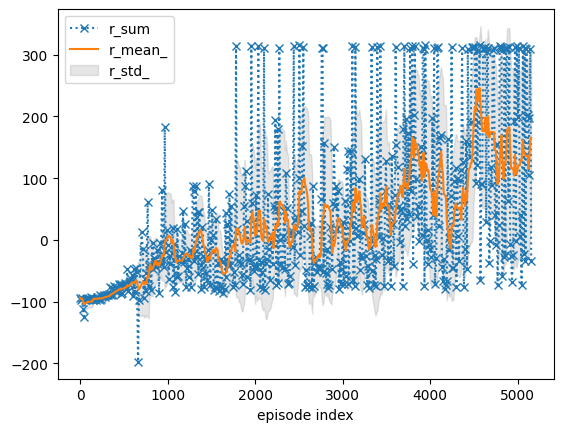

Episode: 4700/5000, Score: 310.95, Steps: 901, Smoothed Score: 161.14, Exploration: 0.0500
Evaluation - Mean Reward: 183.21, Mean Steps: 719.40


In [ ]:
import numpy as np
import torch
import rldurham as rld
import matplotlib.pyplot as plt
import os
import time
from collections import deque
import seaborn as sns
import pandas as pd
from datetime import datetime

# Make sure necessary directories exist
os.makedirs("actor", exist_ok=True)
os.makedirs("critic", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Environment setup using rldurham/Walker
# env = rld.make("rldurham/Walker", render_mode="rgb_array")
env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True)  # only attempt this when your agent has solved the non-hardcore version

# Get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,  # track rolling averages (useful for plotting)
    video=True,  # enable recording videos
    video_folder="videos",  # folder for videos
    video_prefix="your-username-agent-video",  # replace with your username
    logs=True,  # keep logs
)

# Training on CPU recommended
rld.check_device()

# Environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

# Render start image
rld.render(env)

# Check if the environment has continuous action space
env_with_Dead = True  # Whether the Env has dead state
state_dim = obs_dim
action_dim = act_dim
max_action = 1.0  # Walker environment typically has actions scaled to [-1, 1]

print(' state_dim:', state_dim, ' action_dim:', action_dim, 
      ' max_a:', max_action, ' min_a:', -max_action)

# Training parameters
max_episodes = 5000
max_timesteps = 2000
save_interval = 100
eval_interval = 50  # Evaluate agent every 50 episodes
num_eval_episodes = 5  # Number of episodes for evaluation
initial_expl_noise = 0.25  # Starting exploration noise
final_expl_noise = 0.05  # Final exploration noise
expl_decay = 0.999  # Decay rate per episode

# Set random seeds (already set by seed_everything but keeping for clarity)
torch.manual_seed(seed)
np.random.seed(seed)

# Create the agent
kwargs = {
    "env_with_Dead": env_with_Dead,
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "gamma": 0.99,
    "net_width": 200,
    "a_lr": 1e-4,
    "c_lr": 1e-4,
    "Q_batchsize": 256,
}

# Modify the TD3 class to track and return loss values
class TD3_with_metrics(TD3):
    def train(self, replay_buffer):
        self.delay_counter += 1
        with torch.no_grad():
            s, a, r, s_prime, dead_mask = replay_buffer.sample(self.Q_batchsize)
            noise = (torch.randn_like(a) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            smoothed_target_a = (
                    self.actor_target(s_prime) + noise  # Noisy on target action
            ).clamp(-self.max_action, self.max_action)

        # Compute the target Q value
        target_Q1, target_Q2 = self.q_critic_target(s_prime, smoothed_target_a)
        target_Q = torch.min(target_Q1, target_Q2)
        '''DEAD OR NOT'''
        if self.env_with_Dead:
            target_Q = r + (1 - dead_mask) * self.gamma * target_Q  # env with dead
        else:
            target_Q = r + self.gamma * target_Q  # env without dead

        # Get current Q estimates
        current_Q1, current_Q2 = self.q_critic(s, a)

        # Compute critic loss
        q_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize the q_critic
        self.q_critic_optimizer.zero_grad()
        q_loss.backward()
        self.q_critic_optimizer.step()

        # Initialize actor loss
        a_loss = torch.tensor(0.0)

        if self.delay_counter == self.delay_freq:
            # Update Actor
            a_loss = -self.q_critic.Q1(s, self.actor(s)).mean()
            self.actor_optimizer.zero_grad()
            a_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.q_critic.parameters(), self.q_critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            self.delay_counter = -1

        # Return loss values for tracking
        return q_loss.item(), a_loss.item(), target_Q.mean().item(), current_Q1.mean().item(), current_Q2.mean().item()
    
    def get_value_estimate(self, state):
        """Estimate the value of a state using the critic"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state.reshape(1, -1)).to(device)
            action = self.actor(state_tensor)
            q1, q2 = self.q_critic(state_tensor, action)
            return min(q1.item(), q2.item())

# Evaluation function to assess agent without exploration
def evaluate_agent(agent, env, num_episodes=5, render=False):
    """Evaluate agent performance over multiple episodes without exploration"""
    eval_rewards = []
    eval_steps = []
    eval_values = []
    
    for ep in range(num_episodes):
        observation, info = env.reset()
        episode_reward = 0
        episode_values = []
        steps = 0
        done = False
        
        while not done and steps < max_timesteps:
            steps += 1
            
            # Get value estimate for the state
            value = agent.get_value_estimate(observation)
            episode_values.append(value)
            
            # Select action without exploration noise
            action = agent.select_action(observation)
            
            next_observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            done = terminated or truncated
            observation = next_observation
            
            if render and ep == 0:  # Only render first episode
                env.render()
        
        eval_rewards.append(episode_reward)
        eval_steps.append(steps)
        eval_values.append(np.mean(episode_values))
    
    return {
        'mean_reward': np.mean(eval_rewards),
        'mean_steps': np.mean(eval_steps),
        'mean_value': np.mean(eval_values),
        'rewards': eval_rewards
    }

# Sample states from environment for tracking value function
def sample_states(env, agent, num_states=100):
    """Sample diverse states from the environment by taking random actions"""
    states = []
    observation, _ = env.reset()
    states.append(observation.copy())
    
    for _ in range(num_states - 1):
        # Take random action with probability 0.7, otherwise use policy
        if np.random.random() < 0.7:
            action = np.random.uniform(-max_action, max_action, size=action_dim)
        else:
            action = agent.select_action(observation)
            
        next_observation, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            next_observation, _ = env.reset()
        
        states.append(next_observation.copy())
        observation = next_observation
        
    return np.array(states)

# Initialize metrics tracking
metrics = {
    'episodes': [],
    'timesteps': [],
    'rewards': [],
    'smoothed_rewards': [],
    'exploration_noise': [],
    'critic_losses': [],
    'actor_losses': [],
    'target_q_values': [],
    'current_q1_values': [],
    'current_q2_values': [],
    'eval_rewards': [],
    'eval_steps': [],
    'value_estimates': [],
    'episode_lengths': [],
    'actor_entropy': []
}

# Create agent with the modified class
agent = TD3_with_metrics(**kwargs)

# Create replay buffer
replay_buffer = ReplayBuffer.ReplayBuffer(state_dim, action_dim, max_size=int(1e6))

# Sample initial states for value function tracking
fixed_states = None  # Will be set after initial exploration

# Track statistics for plotting
tracker = rld.InfoTracker()
all_ep_r = []

# Total timesteps counter
total_timesteps = 0

# Training procedure
for episode in range(max_episodes):
    # Recording statistics and video
    env.info = episode % 10 == 0  # track every x episodes
    env.video = episode % 50 == 0  # record videos every x episodes
    
    # Reset for new episode
    observation, info = env.reset()
    episode_reward = 0
    steps = 0
    
    # Calculate current exploration noise with decay
    expl_noise = max(final_expl_noise, initial_expl_noise * (expl_decay ** episode))
    
    # Episode metrics
    episode_critic_losses = []
    episode_actor_losses = []
    episode_target_q_values = []
    episode_current_q1_values = []
    episode_current_q2_values = []
    episode_actions = []
    
    # Episode loop
    for t in range(max_timesteps):
        steps += 1
        total_timesteps += 1
        
        # Select action with exploration noise
        action = (
            agent.select_action(observation) + 
            np.random.normal(0, max_action * expl_noise, size=action_dim)
        ).clip(-max_action, max_action)
        
        # Store clean actions for analysis
        episode_actions.append(action.copy())
        
        # Take action in the environment
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        # Accumulate episode reward
        episode_reward += reward
        
        # Check whether done
        done = terminated or truncated
        
        # Special reward handling for Walker environments
        if reward <= -100 and env_with_Dead:
            reward = -1
            replay_buffer.add(observation, action, reward, next_observation, True)
        else:
            replay_buffer.add(observation, action, reward, next_observation, done)
        
        # Update current observation
        observation = next_observation
        
        # Train the agent if buffer has enough samples
        if replay_buffer.size > 2000:
            c_loss, a_loss, target_q, current_q1, current_q2 = agent.train(replay_buffer)
            episode_critic_losses.append(c_loss)
            episode_actor_losses.append(a_loss)
            episode_target_q_values.append(target_q)
            episode_current_q1_values.append(current_q1)
            episode_current_q2_values.append(current_q2)
        
        # Stop episode if done
        if done:
            break
    
    # After initial exploration, sample fixed states for value tracking
    if episode == 20 and fixed_states is None:
        fixed_states = sample_states(env, agent, num_states=50)
    
    # Calculate value estimates on fixed states
    current_value_estimate = 0
    if fixed_states is not None:
        values = []
        for state in fixed_states:
            values.append(agent.get_value_estimate(state))
        current_value_estimate = np.mean(values)
    
    # Calculate action entropy/diversity as the standard deviation across actions
    if len(episode_actions) > 0:
        episode_actions = np.array(episode_actions)
        action_entropy = np.mean(np.std(episode_actions, axis=0))
    else:
        action_entropy = 0
    
    # Calculate mean metrics for the episode
    mean_critic_loss = np.mean(episode_critic_losses) if episode_critic_losses else 0
    mean_actor_loss = np.mean(episode_actor_losses) if episode_actor_losses else 0
    mean_target_q = np.mean(episode_target_q_values) if episode_target_q_values else 0
    mean_current_q1 = np.mean(episode_current_q1_values) if episode_current_q1_values else 0
    mean_current_q2 = np.mean(episode_current_q2_values) if episode_current_q2_values else 0
    
    # Save model at specified intervals
    if (episode + 1) % save_interval == 0:
        agent.save(episode + 1)
    
    # Record and log statistics
    if episode == 0:
        all_ep_r.append(episode_reward)
    else:
        all_ep_r.append(all_ep_r[-1] * 0.9 + episode_reward * 0.1)
    
    # Evaluation phase
    eval_results = None
    if (episode + 1) % eval_interval == 0:
        eval_results = evaluate_agent(agent, env, num_episodes=num_eval_episodes)
        metrics['eval_rewards'].append(eval_results['mean_reward'])
        metrics['eval_steps'].append(eval_results['mean_steps'])
    
    # Update metrics
    metrics['episodes'].append(episode)
    metrics['timesteps'].append(total_timesteps)
    metrics['rewards'].append(episode_reward)
    metrics['smoothed_rewards'].append(all_ep_r[-1])
    metrics['exploration_noise'].append(expl_noise)
    metrics['critic_losses'].append(mean_critic_loss)
    metrics['actor_losses'].append(mean_actor_loss)
    metrics['target_q_values'].append(mean_target_q)
    metrics['current_q1_values'].append(mean_current_q1)
    metrics['current_q2_values'].append(mean_current_q2)
    metrics['value_estimates'].append(current_value_estimate)
    metrics['episode_lengths'].append(steps)
    metrics['actor_entropy'].append(action_entropy)
    
    # Track and plot statistics from rldurham library
    tracker.track(info)
    
    # Print status
    if (episode + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))
        print(f'Episode: {episode+1}/{max_episodes}, Score: {episode_reward:.2f}, Steps: {steps}, '
              f'Smoothed Score: {all_ep_r[-1]:.2f}, Exploration: {expl_noise:.4f}')
        
        if eval_results:
            print(f'Evaluation - Mean Reward: {eval_results["mean_reward"]:.2f}, '
                  f'Mean Steps: {eval_results["mean_steps"]:.2f}')
    
    # Plot comprehensive metrics every 100 episodes
    if (episode + 1) % 100 == 0 or episode == max_episodes - 1:
        # Create a timestamp for the plots
        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        
        # Convert metrics to DataFrame for easier plotting
        df = pd.DataFrame({
            'Episode': metrics['episodes'],
            'Timestep': metrics['timesteps'],
            'Reward': metrics['rewards'],
            'Smoothed Reward': metrics['smoothed_rewards'],
            'Exploration Noise': metrics['exploration_noise'],
            'Critic Loss': metrics['critic_losses'],
            'Actor Loss': metrics['actor_losses'],
            'Target Q-Value': metrics['target_q_values'],
            'Q1-Value': metrics['current_q1_values'],
            'Q2-Value': metrics['current_q2_values'],
            'Value Estimate': metrics['value_estimates'],
            'Episode Length': metrics['episode_lengths'],
            'Action Entropy': metrics['actor_entropy']
        })
        
        # Create evaluation dataframe
        eval_df = pd.DataFrame({
            'Episode': [metrics['episodes'][i] for i in range(0, len(metrics['episodes']), eval_interval)],
            'Eval Reward': metrics['eval_rewards'],
            'Eval Steps': metrics['eval_steps']
        })
        
        # Plot multiple metrics
        fig, axs = plt.subplots(3, 2, figsize=(15, 15))
        
        # Plot 1: Training & Evaluation Rewards
        ax1 = axs[0, 0]
        ax1.plot(df['Episode'], df['Smoothed Reward'], label='Training (Smoothed)')
        ax1.plot(df['Episode'], df['Reward'], alpha=0.3, label='Training (Raw)')
        if len(eval_df) > 0:
            ax1.plot(eval_df['Episode'], eval_df['Eval Reward'], 'r--', label='Evaluation')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Reward')
        ax1.set_title('Training & Evaluation Rewards')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Exploration Noise & Action Entropy
        ax2 = axs[0, 1]
        ax2.plot(df['Episode'], df['Exploration Noise'], label='Exploration Noise')
        ax2_twin = ax2.twinx()
        ax2_twin.plot(df['Episode'], df['Action Entropy'], 'g--', label='Action Entropy')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Exploration Noise')
        ax2_twin.set_ylabel('Action Entropy', color='g')
        ax2.set_title('Exploration & Action Diversity')
        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Loss Values
        ax3 = axs[1, 0]
        ax3.plot(df['Episode'], df['Critic Loss'], label='Critic Loss')
        ax3_twin = ax3.twinx()
        ax3_twin.plot(df['Episode'], df['Actor Loss'], 'r--', label='Actor Loss')
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Critic Loss')
        ax3_twin.set_ylabel('Actor Loss', color='r')
        ax3.set_title('Loss Values During Training')
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Q-Values
        ax4 = axs[1, 1]
        ax4.plot(df['Episode'], df['Target Q-Value'], label='Target Q')
        ax4.plot(df['Episode'], df['Q1-Value'], label='Q1')
        ax4.plot(df['Episode'], df['Q2-Value'], label='Q2')
        ax4.plot(df['Episode'], df['Value Estimate'], 'k--', label='Value Estimate')
        ax4.set_xlabel('Episode')
        ax4.set_ylabel('Q-Value')
        ax4.set_title('Q-Value Estimates')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # Plot 5: Episode Length
        ax5 = axs[2, 0]
        ax5.plot(df['Episode'], df['Episode Length'])
        ax5.set_xlabel('Episode')
        ax5.set_ylabel('Steps')
        ax5.set_title('Episode Length')
        ax5.grid(True, alpha=0.3)
        
        # Plot 6: Training vs Evaluation comparison
        ax6 = axs[2, 1]
        if len(eval_df) > 0:
            training_at_eval = [metrics['smoothed_rewards'][i] for i in range(0, len(metrics['episodes']), eval_interval)]
            x = eval_df['Episode']
            ax6.plot(x, training_at_eval, label='Training')
            ax6.plot(x, eval_df['Eval Reward'], 'r--', label='Evaluation')
            ax6.fill_between(x, training_at_eval, eval_df['Eval Reward'], alpha=0.2, 
                           where=np.array(eval_df['Eval Reward']) >= np.array(training_at_eval),
                           color='green', interpolate=True)
            ax6.fill_between(x, training_at_eval, eval_df['Eval Reward'], alpha=0.2, 
                           where=np.array(eval_df['Eval Reward']) < np.array(training_at_eval),
                           color='red', interpolate=True)
            ax6.set_xlabel('Episode')
            ax6.set_ylabel('Reward')
            ax6.set_title('Training vs Evaluation Reward')
            ax6.legend()
            ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'plots/training_metrics_ep{episode+1}.png')
        plt.close()
        
        # Save metrics to CSV
        df.to_csv(f'logs/training_metrics_ep{episode+1}.csv', index=False)
        if len(eval_df) > 0:
            eval_df.to_csv(f'logs/eval_metrics_ep{episode+1}.csv', index=False)

# Don't forget to close environment (e.g. triggers last video save)
env.close()

# Write log file (for coursework)
env.write_log(folder="logs", file="your-username-agent-log.txt")  # replace with your username

print("Training complete!")
print(f"Final smoothed reward: {all_ep_r[-1]:.2f}")
print(f"Best evaluation reward: {max(metrics['eval_rewards']) if metrics['eval_rewards'] else 'N/A'}")

### Demo

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [ ]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()